In [2]:
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.nn.functional import kl_div

torch.manual_seed(1337)

!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# data loading
def get_batch(split):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    # Define the loss functions
    ce_loss_func = nn.CrossEntropyLoss()

    # Prepare dictionaries to store the output losses
    dlite_out = {}
    ce_out = {}
    kl_out = {}

    model.eval()  # Set the model to evaluation mode
    for split in ['train', 'val']:
        dlite_losses = torch.zeros(eval_iters)
        ce_losses = torch.zeros(eval_iters)
        kl_losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, _ = model(X, Y)

            # Reshape the logits
            logits_flat = logits.view(-1, logits.size(-1))  # Flattening the logits

            # Convert targets to one-hot encoding
            targets_flat = Y.view(-1)

            # Calculate the losses
            dlite_losses[k] = dlite_loss(logits_flat, targets_flat).item()
            ce_losses[k] = ce_loss_func(logits_flat, targets_flat).item()  # Assuming vocab_size is the same as logits.size(-1)
            kl_losses[k] = kl_loss(logits_flat, targets_flat).item()

        # Store the mean loss for each metric
        dlite_out[split] = dlite_losses.mean().item()
        ce_out[split] = ce_losses.mean().item()
        kl_out[split] = kl_losses.mean().item()


    model.train()  # Set the model back to training mode
    return dlite_out, ce_out, kl_out



class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x, targets=None):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)

        if targets is not None:
            # Calculate L1 Loss
            B, T, C = out.shape
            out_flat = out.view(B * T, C)
            targets_flat = targets.view(B * T)
            l1_loss = F.l1_loss(out_flat, targets_flat.float())
            return out, l1_loss
        else:
            return out


class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x


# DLITE Loss function
class DLITELoss(nn.Module):
    def __init__(self):
        super(DLITELoss, self).__init__()

    def forward(self, logits, targets, epsilon=1e-10):
        # Convert logits to probabilities using softmax
        probs = F.softmax(logits, dim=-1)

        # One-hot encode the targets to get true probabilities
        true_probs = F.one_hot(targets, num_classes=probs.size(-1)).float()

        # Define the g function
        g_values = torch.abs(probs * (1 - torch.log(probs + epsilon)) - true_probs * (1 - torch.log(true_probs + epsilon)))

        # Define the delta_h function
        delta_h_values = torch.abs(probs**2 * (1 - 2 * torch.log(probs + epsilon)) - true_probs**2 * (1 - 2 * torch.log(true_probs + epsilon))) / (2 * (probs + true_probs))

        # Compute DLITE loss for each class
        dl_values = g_values - delta_h_values

        # Sum over all classes and average over batch size
        loss = dl_values.sum(dim=-1).mean()

        return loss



# class DLITELoss(nn.Module):
#     def __init__(self):
#         super(DLITELoss, self).__init__()

#     def forward(self, input_logits, target_labels):
#         # Calculate the model's predicted probability distribution corresponding to input logits
#         input_probs = F.softmax(input_logits, dim=-1)

#         # Create a zero tensor with the same shape as input logits to represent the true probability distribution
#         target_probs = torch.zeros_like(input_probs)

#         # Fill the target probability distribution with true labels
#         target_probs.scatter_(dim=-1, index=target_labels.unsqueeze(-1), value=1)

#         # Masks for non-zero elements of input_probs and target_probs
#         mask_input = input_probs > 0
#         mask_target = target_probs > 0

#         # LIT(P, Q) part
#         LIT_input = torch.zeros_like(input_probs)
#         LIT_target = torch.zeros_like(target_probs)

#         # Compute only for non-zero elements
#         LIT_input[mask_input] = input_probs[mask_input] * (1 - torch.log(input_probs[mask_input]))
#         LIT_target[mask_target] = target_probs[mask_target] * (1 - torch.log(target_probs[mask_target]))

#         LIT_term = torch.sum(torch.abs(LIT_input - LIT_target))

#         # dH(P, Q) part
#         dH_input = torch.zeros_like(input_probs)
#         dH_target = torch.zeros_like(target_probs)

#         # Compute only for non-zero elements
#         dH_input[mask_input] = input_probs[mask_input]**2 * (1 - 2*torch.log(input_probs[mask_input]))
#         dH_target[mask_target] = target_probs[mask_target]**2 * (1 - 2*torch.log(target_probs[mask_target]))

#         dH_term = torch.sum(torch.abs(dH_input - dH_target) / (2 * (input_probs + target_probs)))

#         # DLITE(P, Q)
#         DLITE = LIT_term - dH_term

#         return DLITE





class KLDivergenceLoss(nn.Module):
    def __init__(self, reduction='mean'):
        super(KLDivergenceLoss, self).__init__()
        self.reduction = reduction

    def forward(self, input_logits, target_labels):
        # Calculate the model's predicted probability distribution corresponding to input logits
        input_probs = F.log_softmax(input_logits, dim=-1)

        # Create a zero tensor with the same shape as input logits to represent the true probability distribution
        target_probs = torch.zeros_like(input_probs)

        # Fill the target probability distribution with true labels
        target_probs.scatter_(dim=-1, index=target_labels.unsqueeze(-1), value=1)

        # Compute KL divergence
        loss = F.kl_div(input_probs, target_probs, reduction=self.reduction)

        return loss





# super simple bigram model
class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)
        self.loss_func = DLITELoss()  # Initialize the DLITE loss function

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = self.loss_func(logits, targets)  # Use DLITE loss here

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx



--2023-10-27 16:35:26--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt.4’

input.txt.4         100%[===================>]   1.06M  --.-KB/s    in 0.06s   

2023-10-27 16:35:26 (17.9 MB/s) - ‘input.txt.4’ saved [1115394/1115394]



## train with dlite

0.209729 M parameters


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:2943: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


step 0: KL train loss 0.0679, KL val loss 0.0677
DLITE train loss 0.9281, DLITE val loss 0.9275
CE train loss 4.4116, CE val loss 4.4022

step 100: KL train loss 0.0512, KL val loss 0.0523
DLITE train loss 0.6724, DLITE val loss 0.6736
CE train loss 3.3285, CE val loss 3.4020

step 200: KL train loss 0.0513, KL val loss 0.0526
DLITE train loss 0.6472, DLITE val loss 0.6496
CE train loss 3.3351, CE val loss 3.4167

step 300: KL train loss 0.0512, KL val loss 0.0530
DLITE train loss 0.6312, DLITE val loss 0.6367
CE train loss 3.3301, CE val loss 3.4453

step 400: KL train loss 0.0501, KL val loss 0.0515
DLITE train loss 0.6191, DLITE val loss 0.6233
CE train loss 3.2562, CE val loss 3.3502

step 500: KL train loss 0.0497, KL val loss 0.0511
DLITE train loss 0.6067, DLITE val loss 0.6125
CE train loss 3.2298, CE val loss 3.3183

step 600: KL train loss 0.0474, KL val loss 0.0479
DLITE train loss 0.5903, DLITE val loss 0.5917
CE train loss 3.0780, CE val loss 3.1123

step 700: KL train los

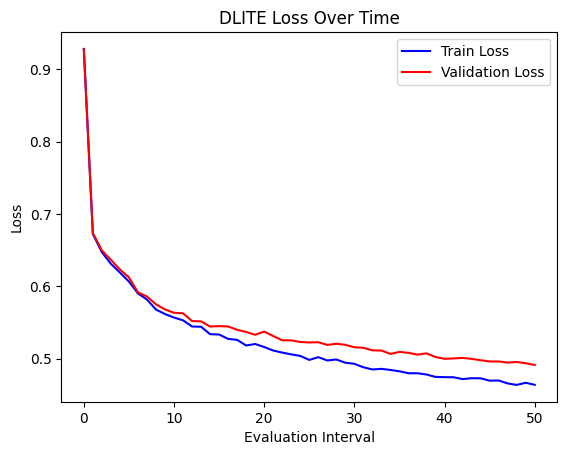

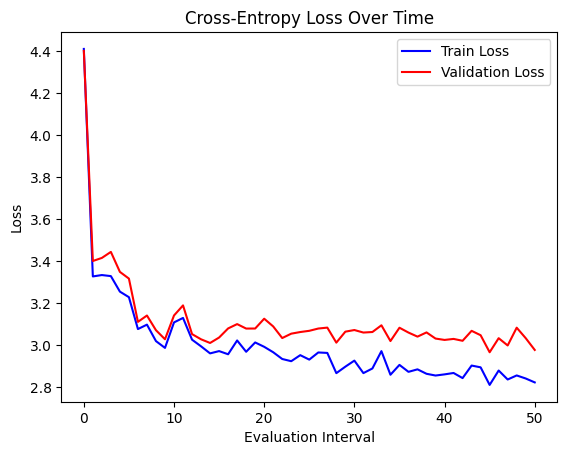

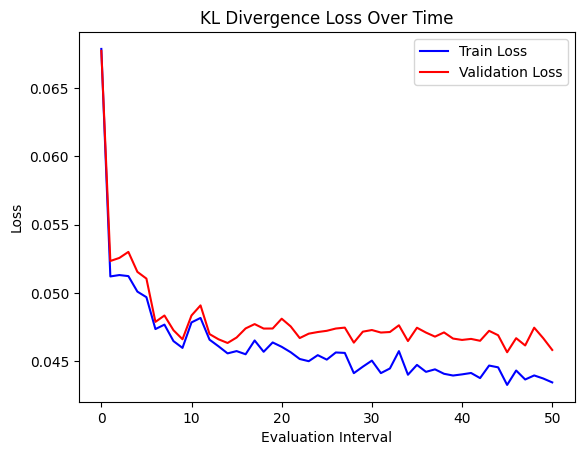

In [3]:
import torch
import torch.nn as nn
from torch.nn import functional as F

# hyperparameters
batch_size = 16 # how many independent sequences will we process in parallel?
block_size = 32 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 100
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 64
n_head = 4
n_layer = 4
dropout = 0.0
# ------------

torch.manual_seed(1337)

model = BigramLanguageModel()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')


# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
dlite_loss = DLITELoss()
kl_loss = KLDivergenceLoss()

# Lists to store the loss values
dlite_train_losses_dlite = []
dlite_val_losses_dlite = []
ce_train_losses_dlite = []
ce_val_losses_dlite = []
kl_train_losses_dlite = []
kl_val_losses_dlite = []



for iter in range(max_iters):
    if iter % eval_interval == 0 or iter == max_iters - 1:
        dlite_losses, ce_losses, kl_losses = estimate_loss()
        print(f"step {iter}: KL train loss {kl_losses['train']:.4f}, KL val loss {kl_losses['val']:.4f}")
        print(f"DLITE train loss {dlite_losses['train']:.4f}, DLITE val loss {dlite_losses['val']:.4f}")
        print(f"CE train loss {ce_losses['train']:.4f}, CE val loss {ce_losses['val']:.4f}\n")


        # Append the losses for this iteration
        dlite_train_losses_dlite.append(dlite_losses['train'])
        dlite_val_losses_dlite.append(dlite_losses['val'])
        ce_train_losses_dlite.append(ce_losses['train'])
        ce_val_losses_dlite.append(ce_losses['val'])
        kl_train_losses_dlite.append(kl_losses['train'])
        kl_val_losses_dlite.append(kl_losses['val'])


    # Sample a batch of data
    xb, yb = get_batch('train')

    # Evaluate the logits
    logits, _ = model(xb, yb)

    # Flatten the logits and target tensor
    logits_flat = logits.view(-1, logits.shape[-1])
    targets_flat = yb.view(-1)


    # Compute the DLITE loss using the flattened logits and targets
    loss = dlite_loss(logits_flat, targets_flat)

    # Backpropagation and optimization step
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()


!pip install matplotlib
import matplotlib.pyplot as plt

def plot_losses(train_losses, val_losses, title):
    # Convert the lists to arrays for mathematical operations.
    train_losses = np.array(train_losses)
    val_losses = np.array(val_losses)

    # Create a new figure
    plt.figure()

    # Plot training and validation losses.
    plt.plot(train_losses, label='Train Loss', color='blue')
    plt.plot(val_losses, label='Validation Loss', color='red')

    # Add titles, labels, and legend.
    plt.title(title)
    plt.xlabel('Evaluation Interval')
    plt.ylabel('Loss')
    plt.legend()

    # Show plot
    plt.show()

# Convert evaluation interval steps to actual iterations
eval_points = [i * eval_interval for i in range(len(dlite_train_losses_dlite))]

# Plotting DLITE Loss
plot_losses(dlite_train_losses_dlite, dlite_val_losses_dlite, 'DLITE Loss Over Time')

# Plotting Cross-Entropy Loss
plot_losses(ce_train_losses_dlite, ce_val_losses_dlite, 'Cross-Entropy Loss Over Time')

# Plotting KL Divergence Loss
plot_losses(kl_train_losses_dlite, kl_val_losses_dlite, 'KL Divergence Loss Over Time')



## train with CE

0.209729 M parameters
step 0: KL train loss 0.0679, KL val loss 0.0677
DLITE train loss 0.9281, DLITE val loss 0.9275
CE train loss 4.4116, CE val loss 4.4022

step 100: KL train loss 0.0409, KL val loss 0.0410
DLITE train loss 0.6977, DLITE val loss 0.6981
CE train loss 2.6568, CE val loss 2.6670

step 200: KL train loss 0.0386, KL val loss 0.0386
DLITE train loss 0.6712, DLITE val loss 0.6701
CE train loss 2.5091, CE val loss 2.5060

step 300: KL train loss 0.0372, KL val loss 0.0374
DLITE train loss 0.6491, DLITE val loss 0.6506
CE train loss 2.4199, CE val loss 2.4337

step 400: KL train loss 0.0362, KL val loss 0.0363
DLITE train loss 0.6344, DLITE val loss 0.6347
CE train loss 2.3500, CE val loss 2.3563

step 500: KL train loss 0.0353, KL val loss 0.0356
DLITE train loss 0.6187, DLITE val loss 0.6209
CE train loss 2.2961, CE val loss 2.3126

step 600: KL train loss 0.0345, KL val loss 0.0346
DLITE train loss 0.6099, DLITE val loss 0.6097
CE train loss 2.2408, CE val loss 2.2501



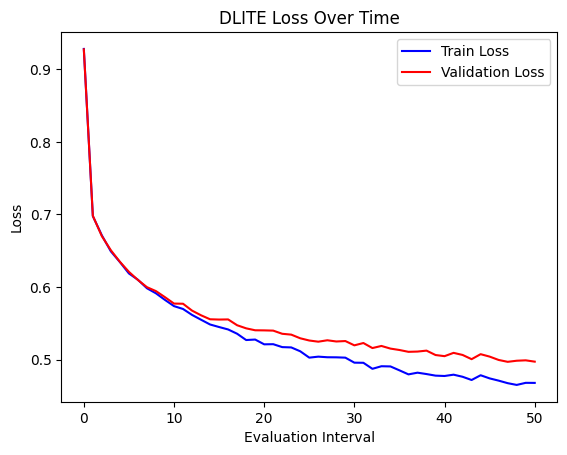

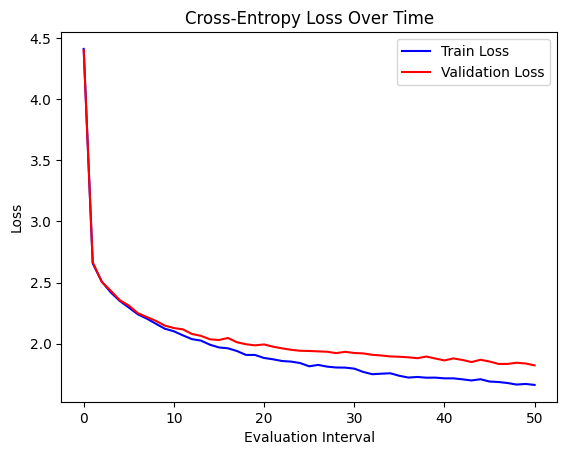

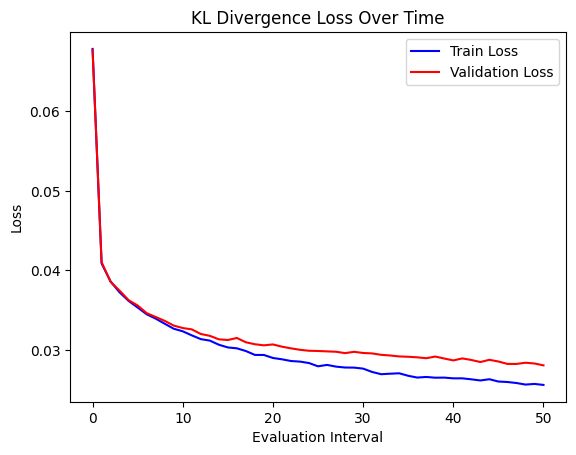

In [4]:
# hyperparameters
batch_size = 16 # how many independent sequences will we process in parallel?
block_size = 32 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 100
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 64
n_head = 4
n_layer = 4
dropout = 0.0

torch.manual_seed(1337)


model = BigramLanguageModel()
m = model.to(device)
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')



# Create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
dlite_loss = DLITELoss()
ce_loss = nn.CrossEntropyLoss()  # Cross-Entropy loss
kl_loss = KLDivergenceLoss()


# Lists to store the loss values
dlite_train_losses_ce = []
dlite_val_losses_ce = []
ce_train_losses_ce = []  # Cross-Entropy train losses
ce_val_losses_ce = []    # Cross-Entropy validation losses
kl_train_losses_ce = []
kl_val_losses_ce = []


for iter in range(max_iters):
    if iter % eval_interval == 0 or iter == max_iters - 1:
        dlite_losses, ce_losses, kl_losses = estimate_loss()
        print(f"step {iter}: KL train loss {kl_losses['train']:.4f}, KL val loss {kl_losses['val']:.4f}")
        print(f"DLITE train loss {dlite_losses['train']:.4f}, DLITE val loss {dlite_losses['val']:.4f}")
        print(f"CE train loss {ce_losses['train']:.4f}, CE val loss {ce_losses['val']:.4f}\n")


        # Append the losses for this iteration
        dlite_train_losses_ce.append(dlite_losses['train'])
        dlite_val_losses_ce.append(dlite_losses['val'])
        ce_train_losses_ce.append(ce_losses['train'])
        ce_val_losses_ce.append(ce_losses['val'])
        kl_train_losses_ce.append(kl_losses['train'])
        kl_val_losses_ce.append(kl_losses['val'])



    # Sample a batch of data
    xb, yb = get_batch('train')

    # Evaluate the logits
    logits, _ = model(xb, yb)

    # Flatten the logits and target tensor
    logits_flat = logits.view(-1, logits.shape[-1])
    targets_flat = yb.view(-1)


    # Compute the CE loss using the flattened logits and targets
    loss = ce_loss(logits_flat, targets_flat)

    # Backpropagation and optimization step
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()


def plot_losses(train_losses, val_losses, title):
    # Convert the lists to arrays for mathematical operations.
    train_losses = np.array(train_losses)
    val_losses = np.array(val_losses)

    # Create a new figure
    plt.figure()

    # Plot training and validation losses.
    plt.plot(train_losses, label='Train Loss', color='blue')
    plt.plot(val_losses, label='Validation Loss', color='red')

    # Add titles, labels, and legend.
    plt.title(title)
    plt.xlabel('Evaluation Interval')
    plt.ylabel('Loss')
    plt.legend()

    # Show plot
    plt.show()

# Convert evaluation interval steps to actual iterations
eval_points = [i * eval_interval for i in range(len(dlite_train_losses_dlite))]

# Plotting DLITE Loss
plot_losses(dlite_train_losses_ce, dlite_val_losses_ce, 'DLITE Loss Over Time')

# Plotting Cross-Entropy Loss
plot_losses(ce_train_losses_ce, ce_val_losses_ce, 'Cross-Entropy Loss Over Time')

# Plotting KL Divergence Loss
plot_losses(kl_train_losses_ce, kl_val_losses_ce, 'KL Divergence Loss Over Time')




## train with KL divergence loss

0.209729 M parameters
step 0: KL train loss 0.0679, KL val loss 0.0677
DLITE train loss 0.9281, DLITE val loss 0.9275
CE train loss 4.4116, CE val loss 4.4022

step 100: KL train loss 0.0409, KL val loss 0.0410
DLITE train loss 0.6977, DLITE val loss 0.6982
CE train loss 2.6571, CE val loss 2.6673

step 200: KL train loss 0.0386, KL val loss 0.0386
DLITE train loss 0.6712, DLITE val loss 0.6702
CE train loss 2.5095, CE val loss 2.5063

step 300: KL train loss 0.0372, KL val loss 0.0374
DLITE train loss 0.6491, DLITE val loss 0.6506
CE train loss 2.4197, CE val loss 2.4338

step 400: KL train loss 0.0362, KL val loss 0.0363
DLITE train loss 0.6344, DLITE val loss 0.6348
CE train loss 2.3508, CE val loss 2.3571

step 500: KL train loss 0.0353, KL val loss 0.0356
DLITE train loss 0.6188, DLITE val loss 0.6211
CE train loss 2.2967, CE val loss 2.3134

step 600: KL train loss 0.0345, KL val loss 0.0346
DLITE train loss 0.6102, DLITE val loss 0.6097
CE train loss 2.2413, CE val loss 2.2498



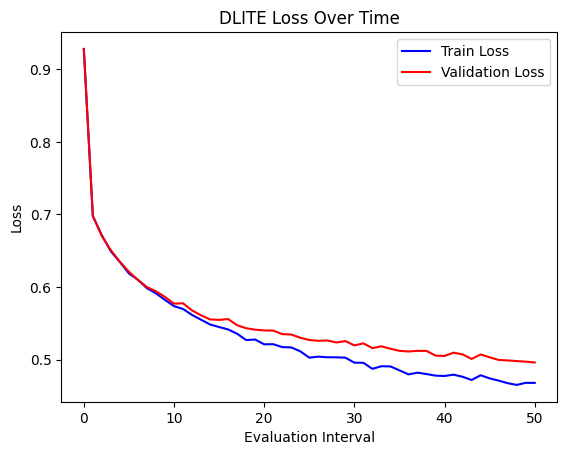

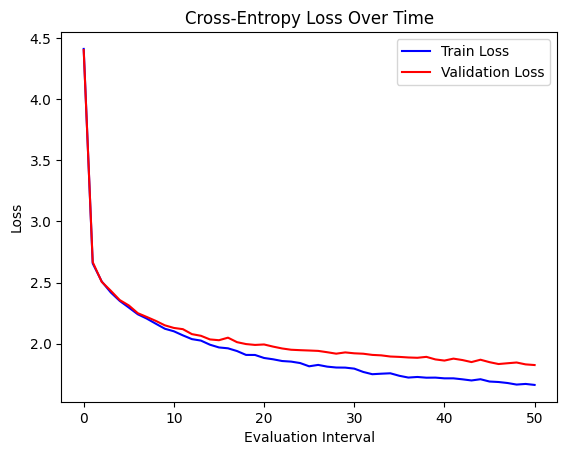

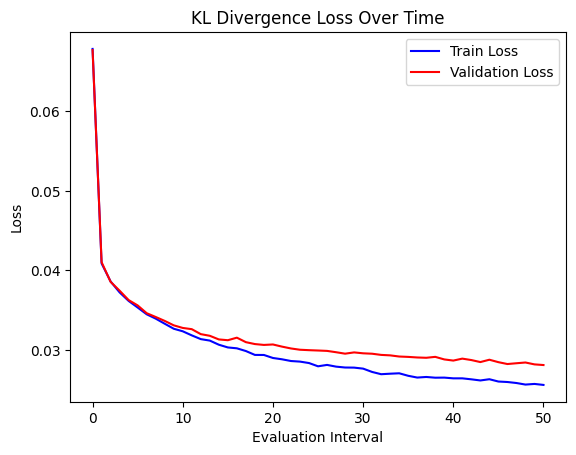

In [5]:
import torch
import torch.nn as nn
from torch.nn import functional as F

# hyperparameters
batch_size = 16
block_size = 32
max_iters = 5000
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(1337)

model = BigramLanguageModel()
m = model.to(device)
print(sum(p.numel() for p in m.parameters()) / 1e6, 'M parameters')

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
dlite_loss = DLITELoss()
ce_loss = nn.CrossEntropyLoss()  # Cross-Entropy loss
kl_loss = KLDivergenceLoss()

# Lists to store the loss values
kl_train_losses_kl = []
kl_val_losses_kl = []
dlite_train_losses_kl = []
dlite_val_losses_kl = []
ce_train_losses_kl = []
ce_val_losses_kl = []

for iter in range(max_iters):
    if iter % eval_interval == 0 or iter == max_iters - 1:
        dlite_losses, ce_losses, kl_losses = estimate_loss()
        print(f"step {iter}: KL train loss {kl_losses['train']:.4f}, KL val loss {kl_losses['val']:.4f}")
        print(f"DLITE train loss {dlite_losses['train']:.4f}, DLITE val loss {dlite_losses['val']:.4f}")
        print(f"CE train loss {ce_losses['train']:.4f}, CE val loss {ce_losses['val']:.4f}\n")

        # Append the losses for this iteration
        kl_train_losses_kl.append(kl_losses['train'])
        kl_val_losses_kl.append(kl_losses['val'])
        dlite_train_losses_kl.append(dlite_losses['train'])
        dlite_val_losses_kl.append(dlite_losses['val'])
        ce_train_losses_kl.append(ce_losses['train'])
        ce_val_losses_kl.append(ce_losses['val'])

    # Sample a batch of data
    xb, yb = get_batch('train')

    # Evaluate the logits
    logits, _ = model(xb, yb)

    # Flatten the logits and target tensor
    logits_flat = logits.view(-1, logits.shape[-1])
    targets_flat = yb.view(-1)

    # Compute the KL Divergence loss using the flattened logits and targets
    kl_loss_value = kl_loss(logits_flat, targets_flat)

    # Backpropagation and optimization step
    optimizer.zero_grad(set_to_none=True)
    kl_loss_value.backward()
    optimizer.step()

# Plotting DLITE Loss
plot_losses(dlite_train_losses_ce, dlite_val_losses_kl, 'DLITE Loss Over Time')

# Plotting Cross-Entropy Loss
plot_losses(ce_train_losses_ce, ce_val_losses_kl, 'Cross-Entropy Loss Over Time')

# Plotting KL Divergence Loss
plot_losses(kl_train_losses_ce, kl_val_losses_kl, 'KL Divergence Loss Over Time')
